### Edgar Moises Hernandez-Gonzalez
#### 30/04/20-25/05/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de (11 x n_canales / 2) x 10 [176x10] o [66x10]
##### Validacion cruzada

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (f1_score, confusion_matrix,
                             roc_auc_score, roc_curve)
from scipy.signal import spectrogram
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [2]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
# todos los canales
x = pd.read_csv("/content/drive/My Drive/MentalCalculation/Datos/MeCa15RMFH-3.csv", header=None)

# centrales y parietales
# x = pd.read_csv("../Datos/MeCaCenPar15RMFH-3.csv", header=None)

# ventaneo
# x = pd.read_csv("../Datos/VentaneoMC-15-3.csv", header=None)

# etiquetas
y = pd.read_csv("/content/drive/My Drive/MentalCalculation/Datos/EtiquetasMeCa15RMFH-03.csv", header=None).values

# etiquetas ventaneo
# y = pd.read_csv("../Datos/EtiquetasVenta-15-3.csv", header=None).values

In [4]:
print(x.shape)
print(y.shape)

(304, 43008)
(304, 1)


In [5]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 304


In [6]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 2


In [0]:
# las etiquetas en categorical para poder entrenar data augmentation
# y_categorical = to_categorical(y)

In [0]:
# unir 32 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_todo(data):
  dim = (5, 352) #ancho, alto
  fs = 512
  datos = np.zeros((data.shape[0],352,5))
  temporal = np.zeros((352,5))
  for i in range(data.shape[0]): #n muestras
    for j in range(32): #32 canales
      sig = data.iloc[i, j*1344:(j+1)*1344]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*11:(j+1)*11, :] = Sxx[4:15, :]
    #resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [9]:
# unir 12 canales (centrales y parietales) y resize de tamaño proporcional
'''def unir_espectrogramas_vertical_resize_cp(data):
  dim = (10, 66) #ancho, alto
  fs = 512
  datos = np.zeros((data.shape[0],66,10))
  temporal = np.zeros((132,5))
  for i in range(data.shape[0]): #n muestras
    for j in range(12): #12 canales, centrales y parietales
      sig = data.iloc[i, j*1344:(j+1)*1344]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*11:(j+1)*11, :] = Sxx[4:15, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos'''

'def unir_espectrogramas_vertical_resize_cp(data):\n  dim = (10, 66) #ancho, alto\n  fs = 512\n  datos = np.zeros((data.shape[0],66,10))\n  temporal = np.zeros((132,5))\n  for i in range(data.shape[0]): #n muestras\n    for j in range(12): #12 canales, centrales y parietales\n      sig = data.iloc[i, j*1344:(j+1)*1344]\n      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT\n      temporal[j*11:(j+1)*11, :] = Sxx[4:15, :]\n    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)\n    datos[i] = resized\n    if i % 100 == 0: #esto solo es para ver como avanza\n      print(i)\n  return datos'

In [10]:
# unir 32 canales con ventaneo
'''def unir_espectrogramas_vertical_todo_ventaneo(data):
  dim = (4, 352) #ancho, alto
  fs = 512
  datos = np.zeros((data.shape[0],352,4))
  temporal = np.zeros((352,4))
  for i in range(data.shape[0]): #n muestras
    for j in range(32): #32 canales
      sig = data.iloc[i, j*1024:(j+1)*1024]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*11:(j+1)*11, :] = Sxx[4:15, :]
    #resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos'''

'def unir_espectrogramas_vertical_todo_ventaneo(data):\n  dim = (4, 352) #ancho, alto\n  fs = 512\n  datos = np.zeros((data.shape[0],352,4))\n  temporal = np.zeros((352,4))\n  for i in range(data.shape[0]): #n muestras\n    for j in range(32): #32 canales\n      sig = data.iloc[i, j*1024:(j+1)*1024]\n      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT\n      temporal[j*11:(j+1)*11, :] = Sxx[4:15, :]\n    #resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)\n    datos[i] = temporal\n    if i % 100 == 0: #esto solo es para ver como avanza\n      print(i)\n  return datos'

In [8]:
# llamar a unir_espectrogramas_vertical_resize(data)
# aqui se debe llamar a _todo (32 canales) o _cp (12 canales) o todo_ventaneo
x = unir_espectrogramas_vertical_todo(x)

0
100
200
300


In [9]:
print(x.shape)

(304, 352, 5)


In [10]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

185.49503760951995
1.1923389621659912e-06
1.042790030490446


In [0]:
# convertir a float
x = x.astype('float32')

# escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [12]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.9972852
6.410424e-09
0.005606398


In [13]:
# convertir de 3D a 4D
x = x.reshape((x.shape[0], x.shape[1], x.shape[2], 1))

print(x.shape)

(304, 352, 5, 1)


In [0]:
# data augmentation
# datagen = ImageDataGenerator(width_shift_range=0.25)

In [0]:
mc = ModelCheckpoint('/content/drive/My Drive/MentalCalculation/Modelos/ModelMC_STFT15_3_CV.hdf5',
                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [0]:
skf = StratifiedKFold(n_splits = 5)

In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1

Epoch 00001: val_accuracy improved from -inf to 0.63934, saving model to /content/drive/My Drive/MentalCalculation/Modelos/ModelMC_STFT15_3_CV.hdf5

Epoch 00002: val_accuracy did not improve from 0.63934

Epoch 00003: val_accuracy did not improve from 0.63934

Epoch 00004: val_accuracy did not improve from 0.63934

Epoch 00005: val_accuracy did not improve from 0.63934

Epoch 00006: val_accuracy did not improve from 0.63934

Epoch 00007: val_accuracy did not improve from 0.63934

Epoch 00008: val_accuracy did not improve from 0.63934

Epoch 00009: val_accuracy did not improve from 0.63934

Epoch 00010: val_accuracy did not improve from 0.63934

Epoch 00011: val_accuracy did not improve from 0.63934

Epoch 00012: val_accuracy did not improve from 0.63934

Epoch 00013: val_accuracy did not improve from 0.63934

Epoch 00014: val_accuracy did not improve from 0.63934

Epoch 00015: val_accuracy did not improve from 0.63934

Epoch 00016: val_accuracy did not improve from 0.639

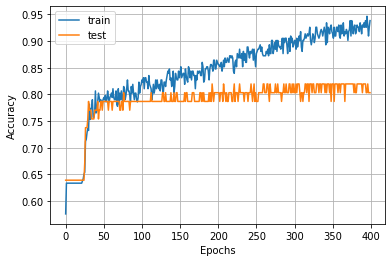

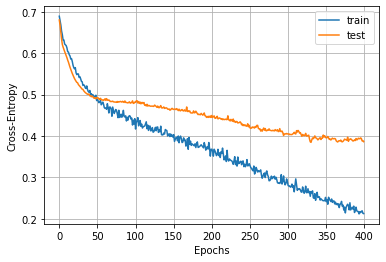


Iteration: 2

Epoch 00001: val_accuracy did not improve from 0.81967

Epoch 00002: val_accuracy did not improve from 0.81967

Epoch 00003: val_accuracy did not improve from 0.81967

Epoch 00004: val_accuracy did not improve from 0.81967

Epoch 00005: val_accuracy did not improve from 0.81967

Epoch 00006: val_accuracy did not improve from 0.81967

Epoch 00007: val_accuracy did not improve from 0.81967

Epoch 00008: val_accuracy did not improve from 0.81967

Epoch 00009: val_accuracy did not improve from 0.81967

Epoch 00010: val_accuracy did not improve from 0.81967

Epoch 00011: val_accuracy did not improve from 0.81967

Epoch 00012: val_accuracy did not improve from 0.81967

Epoch 00013: val_accuracy did not improve from 0.81967

Epoch 00014: val_accuracy did not improve from 0.81967

Epoch 00015: val_accuracy did not improve from 0.81967

Epoch 00016: val_accuracy did not improve from 0.81967

Epoch 00017: val_accuracy did not improve from 0.81967

Epoch 00018: val_accuracy did not

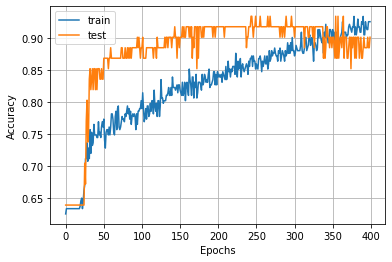

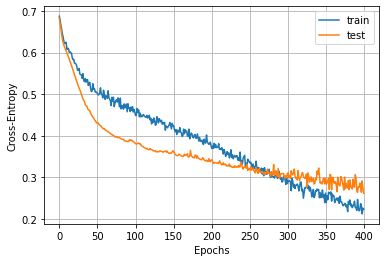


Iteration: 3

Epoch 00001: val_accuracy did not improve from 0.93443

Epoch 00002: val_accuracy did not improve from 0.93443

Epoch 00003: val_accuracy did not improve from 0.93443

Epoch 00004: val_accuracy did not improve from 0.93443

Epoch 00005: val_accuracy did not improve from 0.93443

Epoch 00006: val_accuracy did not improve from 0.93443

Epoch 00007: val_accuracy did not improve from 0.93443

Epoch 00008: val_accuracy did not improve from 0.93443

Epoch 00009: val_accuracy did not improve from 0.93443

Epoch 00010: val_accuracy did not improve from 0.93443

Epoch 00011: val_accuracy did not improve from 0.93443

Epoch 00012: val_accuracy did not improve from 0.93443

Epoch 00013: val_accuracy did not improve from 0.93443

Epoch 00014: val_accuracy did not improve from 0.93443

Epoch 00015: val_accuracy did not improve from 0.93443

Epoch 00016: val_accuracy did not improve from 0.93443

Epoch 00017: val_accuracy did not improve from 0.93443

Epoch 00018: val_accuracy did not

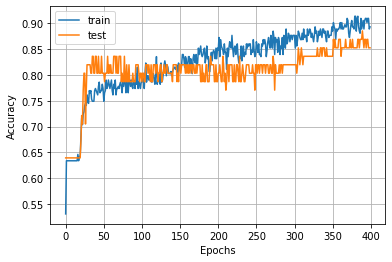

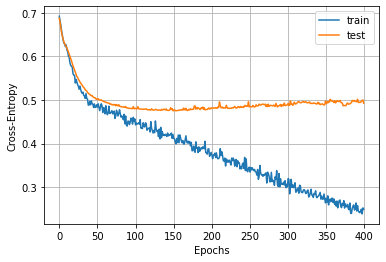


Iteration: 4

Epoch 00001: val_accuracy did not improve from 0.93443

Epoch 00002: val_accuracy did not improve from 0.93443

Epoch 00003: val_accuracy did not improve from 0.93443

Epoch 00004: val_accuracy did not improve from 0.93443

Epoch 00005: val_accuracy did not improve from 0.93443

Epoch 00006: val_accuracy did not improve from 0.93443

Epoch 00007: val_accuracy did not improve from 0.93443

Epoch 00008: val_accuracy did not improve from 0.93443

Epoch 00009: val_accuracy did not improve from 0.93443

Epoch 00010: val_accuracy did not improve from 0.93443

Epoch 00011: val_accuracy did not improve from 0.93443

Epoch 00012: val_accuracy did not improve from 0.93443

Epoch 00013: val_accuracy did not improve from 0.93443

Epoch 00014: val_accuracy did not improve from 0.93443

Epoch 00015: val_accuracy did not improve from 0.93443

Epoch 00016: val_accuracy did not improve from 0.93443

Epoch 00017: val_accuracy did not improve from 0.93443

Epoch 00018: val_accuracy did not

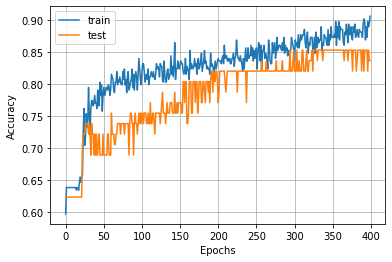

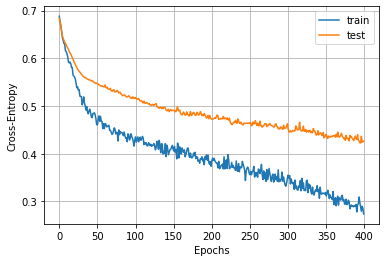


Iteration: 5

Epoch 00001: val_accuracy did not improve from 0.93443

Epoch 00002: val_accuracy did not improve from 0.93443

Epoch 00003: val_accuracy did not improve from 0.93443

Epoch 00004: val_accuracy did not improve from 0.93443

Epoch 00005: val_accuracy did not improve from 0.93443

Epoch 00006: val_accuracy did not improve from 0.93443

Epoch 00007: val_accuracy did not improve from 0.93443

Epoch 00008: val_accuracy did not improve from 0.93443

Epoch 00009: val_accuracy did not improve from 0.93443

Epoch 00010: val_accuracy did not improve from 0.93443

Epoch 00011: val_accuracy did not improve from 0.93443

Epoch 00012: val_accuracy did not improve from 0.93443

Epoch 00013: val_accuracy did not improve from 0.93443

Epoch 00014: val_accuracy did not improve from 0.93443

Epoch 00015: val_accuracy did not improve from 0.93443

Epoch 00016: val_accuracy did not improve from 0.93443

Epoch 00017: val_accuracy did not improve from 0.93443

Epoch 00018: val_accuracy did not

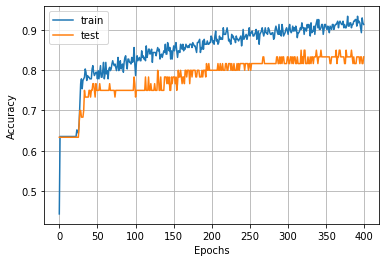

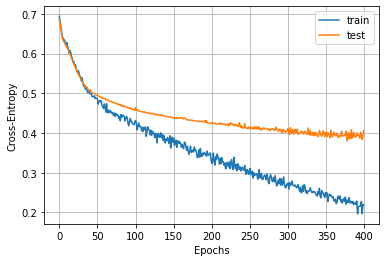


Resultados:
loss: [0.3863931508337865, 0.26170507073402405, 0.4926837653410239, 0.4262108465687173, 0.40583954254786175]
accuracy: [0.8032786846160889, 0.9016393423080444, 0.8524590134620667, 0.8360655903816223, 0.8333333134651184]
f1: [0.7867132867132867, 0.8969594594594594, 0.8383868118928466, 0.8140243902439024, 0.8168498168498168]
auc: [0.907925407925408, 0.9720279720279721, 0.8776223776223776, 0.8832951945080091, 0.894736842105263]
Tiempo: 109.91949343681335


In [17]:
inicio = time.time()
array_loss = []
array_acc = []
array_f1 = []
array_auc = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  model = CNN_2D()
  
  history = model.fit(x_train, y_train, epochs=400, batch_size=20,
                      validation_data=(x_test, y_test),
                      verbose=0, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  f1 = f1_score(y_test, y_pred, average='macro')
  array_f1.append(f1)
  print("f1:", f1)
  
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
  array_auc.append(auc)

  print("AUC", auc)
  #plt.plot(fpr, tpr)
  #plt.grid()
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("f1:", array_f1)
print("auc:", array_auc)
fin = time.time()
print("Tiempo:", fin - inicio)

In [18]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 352, 5, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 176, 2, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 176, 2, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 88, 1, 16)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               180352    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [19]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean F1: %.4f" % np.mean(array_f1))
print("std: (+/- %.4f)" % np.std(array_f1))
print("Mean auc: %.4f" % np.mean(array_auc))
print("std: (+/- %.4f)" % np.std(array_auc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max F1: %.4f" % np.max(array_f1))
print("Max auc: %.4f" % np.max(array_auc))

Mean Accuracy: 0.8454
std: (+/- 0.0323)
Mean F1: 0.8306
std: (+/- 0.0370)
Mean auc: 0.9071
std: (+/- 0.0341)
Max Accuracy: 0.9016
Max F1: 0.8970
Max auc: 0.9720


In [22]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May 25 23:53:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   1131MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  


Iteration: 1
loss:  0.6422575290860801
accuracy:  0.7758620977401733
f1: 0.748917748917749
confusion matrix:
 [[13  8]
 [ 5 32]]
AUC 0.8018018018018017


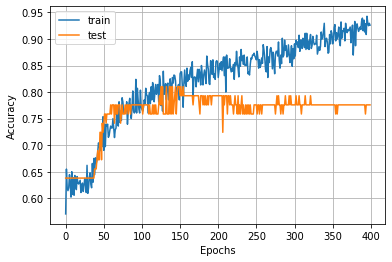

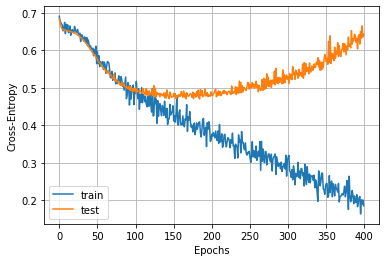


Iteration: 2
loss:  0.7811687403711779
accuracy:  0.6551724076271057
f1: 0.639751552795031
confusion matrix:
 [[13  9]
 [11 25]]
AUC 0.7323232323232323


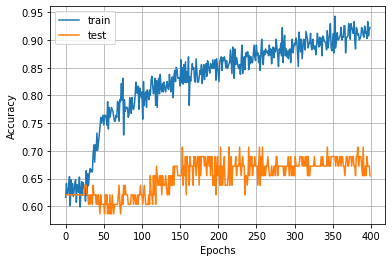

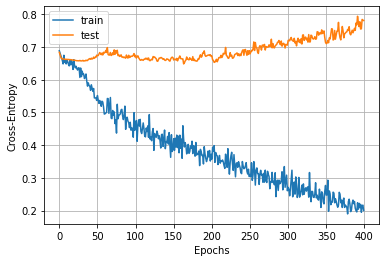


Iteration: 3
loss:  0.4099647073910154
accuracy:  0.7586206793785095
f1: 0.7478260869565216
confusion matrix:
 [[16  6]
 [ 8 28]]
AUC 0.8787878787878788


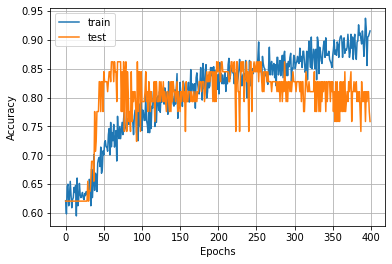

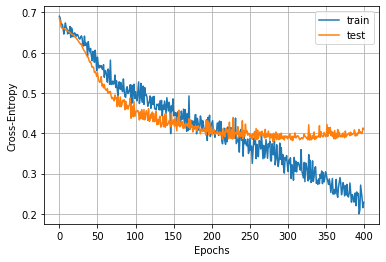


Iteration: 4
loss:  0.49041688442230225
accuracy:  0.719298243522644
f1: 0.6647058823529411
confusion matrix:
 [[ 9 12]
 [ 4 32]]
AUC 0.869047619047619


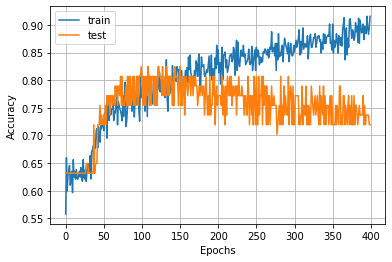

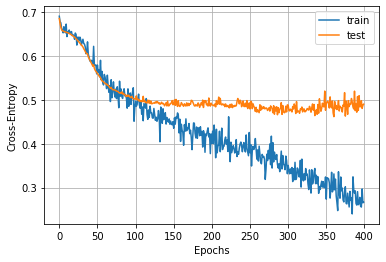


Iteration: 5
loss:  0.6114891202826249
accuracy:  0.8245614171028137
f1: 0.8026315789473684
confusion matrix:
 [[14  7]
 [ 3 33]]
AUC 0.8121693121693121


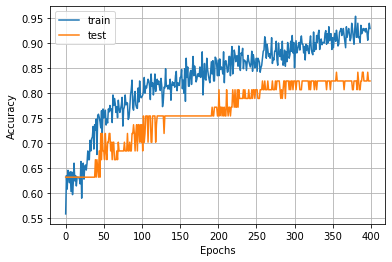

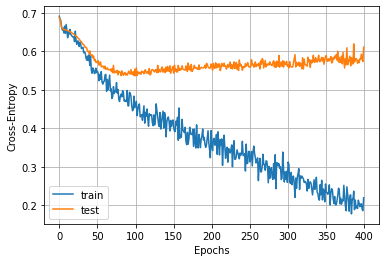


Resultados:
loss: [0.6422575290860801, 0.7811687403711779, 0.4099647073910154, 0.49041688442230225, 0.6114891202826249]
accuracy: [0.7758620977401733, 0.6551724076271057, 0.7586206793785095, 0.719298243522644, 0.8245614171028137]
f1: [0.748917748917749, 0.639751552795031, 0.7478260869565216, 0.6647058823529411, 0.8026315789473684]
auc: [0.8018018018018017, 0.7323232323232323, 0.8787878787878788, 0.869047619047619, 0.8121693121693121]
Tiempo: 299.5477395057678


In [0]:
# data augmentation
'''inicio = time.time()
array_loss = []
array_acc = []
array_f1 = []
array_auc = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]
  y_train_categorical, y_test_categorical = y_categorical[iTrain], y_categorical[jTest]

  model = CNN_2D()
  
  history = model.fit_generator(datagen.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples/18),
                                epochs=400,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0) #callbacks=[mc])
  
  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  f1 = f1_score(y_test, y_pred, average='macro')
  array_f1.append(f1)
  print("f1:", f1)
  
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
  array_auc.append(auc)

  print("AUC", auc)
  #plt.plot(fpr, tpr)
  #plt.grid()
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("f1:", array_f1)
print("auc:", array_auc)
fin = time.time()
print("Tiempo:", fin - inicio)'''

In [0]:
#400 iteraciones todo(75.78)   dropout 0.5(75.46)
# 01ACLL-1 = 80.93%        (80.41)
# 03ATH-3 = 71.02%         (70.84)
# 08GMS-3 = 70.16%         (71.50)
# 15RMFH-3 = 81.01%        (79.07)

#400 iteraciones centrales y parietales(69.76)
# 01ACLL-1 = 79.76
# 03ATH-3 = 63.81
# 08GMS-3 = 59.51
# 15RMFH-3 = 75.97

# Data Augmentation(74.71)
# 01ACLL-1 = 75.97
# 03ATH-3 = 69.48
# 08GMS-3 = 70.92
# 15RMFH-3 = 82.45

# Data Augmentation centrales y parietales(71.54)
# 01ACLL-1 = 79.31
# 03ATH-3 = 67.80
# 08GMS-3 = 61.82
# 15RMFH-3 = 77.21

# Resize 352x10 (74.37) [72.22]
# 01ACLL-1 = 79.73 [77.92]
# 03ATH-3 = 75.76  [72.77]
# 08GMS-3 = 70.43  [68.78]
# 12MMA-1 = 62.91  [61.75]
# 15RMFH-3 = 83.00 [79.86]

#----------Este es el bueno----------
# Resize 352x5 quitar una CNN y pool (73.64) [72.75]
# 01ACLL-1 = 78.92 [77.49]
# 03ATH-3 = 73.17  [73.16]
# 08GMS-3 = 74.34  [74.15]
# 12MMA-1 = 58.90  [57.07]
# 15RMFH-3 = 82.86 [81.88]

# Resize 352x5 quitar una CNN y pool centraes y parietales(69.88)
# 01ACLL-1 = 79.64
# 03ATH-3 = 64.46
# 08GMS-3 = 60.18
# 15RMFH-3 = 75.25

# Resize 352x5 quitar una CNN y pool con data augmentation(75.34)
# 01ACLL-1 = 76.52
# 03ATH-3 = 67.21
# 08GMS-3 = 71.79
# 15RMFH-3 = 85.84

# Ventaneo (76.15)
# 01ACLL-1 = 75.50
# 03ATH-3 = 76.22
# 08GMS-3 = 72.99
# 15RMFH-3 = 79.90

# CNN de BCI IV-2a (77.89)
# 01ACLL-1 = 77.83
# 03ATH-3 = 72.83
# 08GMS-3 = 77.45
# 15RMFH-3 = 83.43

# CNN de BCI IV-2a con Data Augmentation (76.8)
# 01ACLL-1 = 77.14
# 03ATH-3 = 73.60
# 08GMS-3 = 72.08
# 15RMFH-3 = 84.38